# Capsule Neural Network (CapsNet) Implementation

Implementation of the paper [Dynamic Routing Between Capsules](https://arxiv.org/pdf/1710.09829.pdf) by Sara Sabour, Nicholas Frosst, and Geoffrey E. Hinton. Used [jindongwang/Pytorch-CapsuleNet](https://github.com/jindongwang/Pytorch-CapsuleNet) and [laubonghaudoi/CapsNet_guide_PyTorch](https://github.com/laubonghaudoi/CapsNet_guide_PyTorch) to clarify some confusions, and borrowed some code.

## Setup PyTorch

In [3]:
!pip install torch torchvision
!pip install matplotlib
!pip install import-ipynb
!pip install tqdm
!pip install pytorch_extras

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=c0a615f208e633f5fb8e40067102a0abc47ee3ae2f8ca3c5f0b111b8a995db80
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
  Created wheel for pytorch-extras: filename=pytorch_extras-0.1.3-cp37-none-any.whl size=2833 sha256=8eaa185455f6b77e50c7bacfef82236cd08e1c05ccda15f07284cbb0a09717c9
  Stored in directory: /root/.cache/pip/wheels/5b/7c/5a/f27d4088adfe722cb280d523a1ed9eeb33be11b8d3a653292a
Successfully built pytorch-extras


In [4]:
from google.colab import drive
drive.mount("mnt")

Mounted at mnt


In [5]:
%cd "mnt/My Drive"

/content/mnt/My Drive


In [6]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch_extras
import torch.nn as nn
import torchvision.utils as tv_utils
import torch.nn.functional as F
from torch.autograd import Variable
import import_ipynb
import load_DrawData
import numpy as np
import argparse
from tqdm import tqdm
%matplotlib inline
# %mkdir -p /content/project/
# %cd /content/project/

importing Jupyter notebook from load_DrawData.ipynb
     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=4594b485a0e979b2a8454cbcca02efbd052d03fb2acf6382e364851fb4c42118
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
mkdir: cannot create directory ‘quickDrawData’: File exists
gs://quickdraw_dataset/full/simplified/apple.ndjson
Copying gs://quickdraw_dataset/full/simplified/apple.ndjson...
| [1/1 files][ 56.1 MiB/ 56.1 MiB] 100% Done                                    
Operation completed over 1 objects/56.1 MiB.                                     
gs://quickdraw_dataset/full/simplified/face.ndjson
Copying gs://quickdraw_dataset/full/simplified/face.ndjson...
/ [1/1 files][ 89.4 MiB/ 89.4 MiB] 100% Done                                    
Operation completed over 1 objects/89.4 MiB.                         

## CapsNet Modules

In [7]:
def squash(s):
    '''Non-linear "squashing" function to ensure that short vectors get shrunk 
    to almost zero length and long vectors get shrunk to a length slightly 
    below 1. Equation (1) in the paper.
    
    Input:
      s: 	total input vector
    
    Output:
      squashed output vector
    '''
    norm_sqrd = torch.sum(s**2, dim=2, keepdim=True)
    return (norm_sqrd / (1 + norm_sqrd)) * (s / (torch.sqrt(norm_sqrd) + 1e-8))

In [8]:
class PrimaryCapsules(nn.Module):
    '''The layer after Conv1. Section 4 of the paper.
    '''

    def __init__(self):
        super(PrimaryCapsules, self).__init__()
        self.capsules = nn.ModuleList(
            [nn.Conv2d(in_channels=256,
                    out_channels=8,
                    kernel_size=9,
                    stride=2)
            for i in range(32)]
        )

    def forward(self, x):
        '''Section 4 of the paper.

        Input:
        x: outut of the ReLUConv1 layer, of shape (batch_size x 256 x 20 x 20)

        Output:
        squashed PrimaryCapsules output tensor, of shape (batch_size x 1152 x 8)
        '''
        batch_size = x.size(0)
        
        # Get the output of each primary capsule; combine and prepare them to 
        # serve as the input to the next layer (DoodleCapsules)
        all_u = []
        for cap in self.capsules:
            u = cap(x)  # (batch_size x 8 x 6 x 6)
            u = u.view(batch_size, 8, 36, 1)  # (batch_size x 8 x 36 x 1)
            all_u.append(u)
        all_u = torch.cat(all_u, dim=3)  # (batch_size x 8 x 36 x 32)
        all_u = all_u.view(batch_size, 8, -1)  # (batch_size x 8 x 1152)
        all_u = torch.transpose(all_u, 1, 2)  # (batch_size x 1152 x 8)
        all_u = squash(all_u)  # (batch_size x 1152 x 8)
        
        return all_u

In [9]:
class DoodleCapsules(nn.Module):
    '''The layer after PrimaryCapsules. Section 4 of the paper.
    '''

    def __init__(self, opt):
        super(DoodleCapsules, self).__init__()
        self.opt = opt
        self.W = nn.Parameter(torch.randn(1, 1152, opt.n_classes, 8, 16))
    
    def forward(self, u):
        '''Equation (2) and Procedure 1 in the paper.

        Input:
        u: output of the PrimaryCapsules layer, of shape (batch_size x 8)

        Output:
        output tensor of the DoodleCapsules layer, of shape (batch_size x 1152 x n_classes x 1)
        '''
        batch_size = u.size(0)
        
        u = torch.unsqueeze(u, dim=2)  # (batch_size x 1 x 8)
        u = torch.unsqueeze(u, dim=2)  # (batch_size x 1 x 1 x 8)
        u_hat = torch.matmul(u, self.W).squeeze()  # (batch_size x 1152 x n_classes x 16)

        b = Variable(torch.zeros(batch_size, 1152, self.opt.n_classes, 1))  # (batch_size x 1152 x n_classes x 1)
        if self.opt.use_cuda & torch.cuda.is_available(): b = b.cuda()

        for i in range(self.opt.iterations):
            c = F.softmax(b, dim=2)  # (batch_size x 1152 x n_classes x 1)
            s = torch.sum(u_hat * c, dim=1)  # (batch_size x n_classes x 16)
            v = squash(s)  # (batch_size x n_classes x 16)
            b = b + torch.sum(u_hat * v.unsqueeze(1), dim=3, keepdim=True)  # (batch_size x 1152 x n_classes x 1)
        
        return v  # (batch_size x n_classes x 16)

In [10]:
class DoodleDecoder(nn.Module):
    '''Decoder structure to reconstruct the doodle from the output of the DoodleCapsules layer.
    Section 4 of the paper. For an illustrative explaination, see Figure 2 of the paper.
    '''

    def __init__(self, opt):
        super(DoodleDecoder, self).__init__()
        self.opt = opt
        self.layers = nn.Sequential(
            nn.Linear(opt.n_classes * 16, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, opt.height * opt.width),
            nn.Sigmoid()
        )

    def forward(self, v, target):
        '''Takes a 16-dimensional vector v from the *correct* DoodleCapsules, and 
        learns to decode it into an image of a doodle. Mask out the other (n_classes - 1) classes.
        Section 4 of the paper. For an illustrative explaination, see Figure 2 of the paper.

        Input:
        v: output of DoodleCapsules, of shape (batch_size x n_classes x 16)
        target: one-hot targets, of shape (batch_size, n_classes)

        Output:
        decoder constructed images, of shape (batch_size x 784)
        '''
        # TODO: the true target or the most probable?
        # correct = torch.sqrt((v ** 2).sum(2))  # (batch_size x n_classes)
        # correct = F.softmax(correct, dim=0)  # (batch_size x n_classes)
        # correct = correct.max(dim=1)[1]  # (batch_size)
        batch_size = v.size(0)

        # Create the mask, which is 1 only for the correct class and 0 otherwise
        mask = target.type(torch.FloatTensor).unsqueeze(-1)  # (batch_size x n_classes x 1)
        mask = torch.repeat_interleave(mask, 16, dim=2)  # (batch_size x n_classes x 16)
        if self.opt.use_cuda & torch.cuda.is_available(): mask = mask.cuda()
        assert(mask.size() == torch.Size([batch_size, 2, 16]))
        
        masked = (v * mask).view(batch_size, -1)  # (batch_size x n_classes x 16)
        result = self.layers(masked)  # (batch_size x 784)
        assert(result.size() == torch.Size([batch_size, 784]))
        
        return result

In [11]:
class CapsuleNetwork(nn.Module):
    '''Consists of a ReLU Convolution layer, a PrimaryCapsules layer, a DoodleCapsules
    layer, and a Decoder layer. Section 4 of the paper.
    '''

    def __init__(self, opt):
        super(CapsuleNetwork, self).__init__()
        self.opt = opt
        self.ReLUConv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9),
            nn.ReLU()
        )
        self.PrimaryCapsules = PrimaryCapsules()
        self.DoodleCapsules = DoodleCapsules(opt)
        self.DoodleDecoder = DoodleDecoder(opt)
    
    def forward(self, x):
        '''Section 4 of the paper.

        Input:
        the input to the network, of shape (batch_size x 28 x 28)

        Output:
        the output of the network, of shape (batch_size x n_classes x 16)
        '''
        v = torch.unsqueeze(x, 1)
        v = self.ReLUConv1(v)  # (batch_size x 256 x 20 x 20)
        v = self.PrimaryCapsules(v)  # (batch_size x 1152 x 8)
        v = self.DoodleCapsules(v)  # (batch_size x n_classes x 16)
        return v  # (batch_size x n_classes x 16)

    def marginal_loss(self, v, target):
        '''Section 3, Equation (4) of the paper.

        Input:
        v: the output of the network, of shape (batch_size x n_classes x 16)
        target: the one-hot target, of shape (batch_size x n_classes)
        lambd: a scalor for down-weighting of the loss for absent doodle classes
        
        Output:
        marginal loss (a scalor summed over all batches and classes)
        '''
        v_norm = torch.sqrt((v ** 2).sum(dim=2))  # (batch_size x n_classes)
        
        zeros = torch.zeros(v_norm.size())  # (batch_size x n_classes)
        if self.opt.use_cuda & torch.cuda.is_available(): zeros = zeros.cuda()
        
        max1 = torch.max(zeros, 0.9 - v_norm) ** 2  # (batch_size x n_classes)
        max2 = torch.max(zeros, v_norm - 0.1) ** 2  # (batch_size x n_classes) 
        loss = target * max1 + (1 - target) * 0.5 * max2  # (batch_size x n_classes)
        
        return torch.sum(loss)  # scalor

    def reconstruction_loss(self, data, reconstruction):
        '''Reconstruction for regularization. Ecourages the doodle capsules to 
        encode the instantiation parameters of the input doodle. Section 4.1 of the paper.

        Input:
        data: the real image, of shape (batch_size, 28, 28)
        reconstruction: the reconstructed image, of shape (batch_size, 784)

        Output:
        reconstruction loss (a scalor summed over all batches and classes)
        '''
        batch_size = data.size(0)
        return torch.sum((reconstruction - data.view(batch_size, -1)) ** 2)

    def loss(self, v, data, target):
        '''Loss is marginal loss + 0.0005 * reconstruction loss. 0.0005 to ensure
        the reconstruction loss does not dominate the training. Section 4.1 of the paper.

        Input:
        v: output of the network, of shape (batch_size x n_classes x 16)
        target: one-hot target, of shape (batch_size x n_classes)
        data: the input to the network (the image), of shape (batch_size, 28, 28)
        
        Output:
        averaged loss (a scalor) over batches 
        averaged marginal loss (a scalor) over batches
        averaged reconstruction loss (a scalor) over batches
        '''
        batch_size = data.size(0)
        
        marginal_loss = self.marginal_loss(v, target)  # scalor
        
        reconstruction = self.DoodleDecoder(v, target)  # (batch_size, 784)
        reconstruction_loss = self.reconstruction_loss(data, reconstruction)  # scalor
        
        loss = marginal_loss + 0.0005 * reconstruction_loss  # scalor
        
        return loss/batch_size, marginal_loss/batch_size, reconstruction_loss/batch_size

## Training

In [42]:
def get_opts():
    parser = argparse.ArgumentParser(description='CapsuleNetwork')
    parser.add_argument('-batch_size', type=int, default=60)
    parser.add_argument('-lr', type=float, default=1e-5)
    parser.add_argument('-epochs', type=int, default=1000)
    parser.add_argument('-width', type=int, default=28)
    parser.add_argument('-height', type=int, default=28)
    parser.add_argument('-n_classes', type=int, default=2)
    parser.add_argument('-iterations', type=int, default=3)
    parser.add_argument('-use_cuda', default=True)
    parser.add_argument('-print_every', type=int, default=10)
    parser.add_argument('-gamma', type=float, default=0.98)
    opt, _ = parser.parse_known_args()
    return opt

In [43]:
def test(opt, test_loader, model, epoch, num_batches):
    sum_loss = 0
    sum_marginal_loss = 0
    sum_reconstruction_loss = 0
    correct = 0
    num_sample = len(test_loader.dataset)
    num_batch = len(test_loader)

    model.eval()
    for data, target in test_loader:
        data = data.to(torch.float32)
        target = target.to(torch.int64)
        batch_size = data.size(0)
        assert target.size() == torch.Size([batch_size, opt.n_classes])

        # Use GPU if available
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        if opt.use_cuda & torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data)  # (batch_size, n_classes, 16)
        loss, marginal_loss, reconstruction_loss = model.loss(output, data, target)
        sum_loss += loss.item()
        sum_marginal_loss += marginal_loss.item()
        sum_reconstruction_loss += reconstruction_loss.item()

        norms = torch.sqrt(torch.sum(output**2, dim=2))  # (batch_size, n_classes)
        pred = norms.data.max(1, keepdim=True)[1].type(torch.LongTensor)  # (batch_size, 1)
        label = target.max(1, keepdim=True)[1].type(torch.LongTensor)  # (batch_size, 1)
        correct += pred.eq(label.view_as(pred)).cpu().sum().item()

    recons = model.DoodleDecoder(output, target)
    recons = recons.view(batch_size, 1, 28, 28)
    recons = tv_utils.make_grid(recons.data, normalize=True, scale_each=True)

    sum_loss /= num_batch
    sum_marginal_loss /= num_batch
    sum_reconstruction_loss /= num_batch
    
    print('\nTest loss: {:.4f}   Marginal loss: {:.4f}   Reconstruction loss: {:.4f}'.format(
        sum_loss, sum_marginal_loss, sum_reconstruction_loss))
    print('\nAccuracy: {}/{} {:.4f}\n'.format(correct, num_sample,
        correct / num_sample))

In [44]:
def train(opt, train_loader, test_loader, model):
    num_sample = len(train_loader.dataset)
    num_batches = len(train_loader)
    train_loss_list = []
    loss_val = 0.

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, opt.gamma)
    model.train()
    for epoch in range(opt.epochs):
        scheduler.step()

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(torch.float32)
            batch_size = data.size(0)
            target = target.to(torch.int64)
            assert target.size() == torch.Size([batch_size, opt.n_classes])

            # Use GPU if available
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            if opt.use_cuda & torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss, marginal_loss, reconstruction_loss = model.loss(output, data, target)
            loss_val = loss.item()

            # if batch_idx % opt.print_every == 0:
            #      tqdm.write('\nEpoch: {}    Training loss: {:.4f}   Marginal loss: {:.4f}   Reconstruction loss: {:.4f}'.format(epoch, loss.item(), marginal_loss.item(), reconstruction_loss.item()))
            
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0: 
            train_loss_list.append(loss_val)
        if epoch % 100 == 0:
            print('Epoch: {}'.format(epoch))
            print('Learning rate: {:.2e}'.format(scheduler.get_last_lr()[0]))
            test(opt, test_loader, model, epoch, num_batches) 
    fig = plt.figure()
    plt.plot([i for i in range(len(train_loss_list))], train_loss_list, '-')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 0
Learning rate: 9.80e-06

Test loss: 3506.3309   Marginal loss: 0.4050   Reconstruction loss: 7011851.6667

Accuracy: 140/180 0.7778

Epoch: 100
Learning rate: 1.30e-06

Test loss: 3502.4740   Marginal loss: 0.4050   Reconstruction loss: 7004137.8333

Accuracy: 137/180 0.7611

Epoch: 200
Learning rate: 1.72e-07

Test loss: 3501.5273   Marginal loss: 0.4050   Reconstruction loss: 7002244.1667

Accuracy: 140/180 0.7778

Epoch: 300
Learning rate: 2.29e-08

Test loss: 3501.4102   Marginal loss: 0.4050   Reconstruction loss: 7002010.3333

Accuracy: 143/180 0.7944

Epoch: 400
Learning rate: 3.03e-09

Test loss: 3501.3953   Marginal loss: 0.4050   Reconstruction loss: 7001980.5000

Accuracy: 143/180 0.7944

Epoch: 500
Learning rate: 4.02e-10

Test loss: 3501.3937   Marginal loss: 0.4050   Reconstruction loss: 7001977.1667

Accuracy: 141/180 0.7833

Epoch: 600
Learning rate: 5.33e-11

Test loss: 3501.3937   Marginal loss: 0.4050   Reconstruction loss: 7001977.1667

Accuracy: 145/180 0.

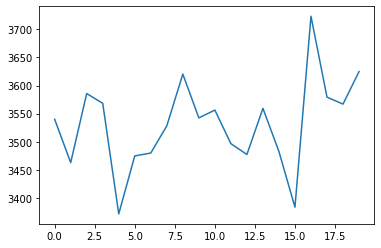

In [45]:
opt = get_opts()

model = CapsuleNetwork(opt)
if opt.use_cuda & torch.cuda.is_available():
    model.cuda()

train_loader = load_DrawData.train_loader
test_loader = load_DrawData.val_loader

train(opt, train_loader, test_loader, model)

In [46]:
print(len(load_DrawData.train_loader.dataset))
print(len(load_DrawData.val_loader.dataset))

#plt.plot(x, np.cos(x), '--');

420
180
